# 1. Computing 1st and 2nd order derivative properties using the FE-ANN EoS

This notebook exemplifies how to use the FE-ANN EoS to compute derivate properties of the Helmholtz free energy.

The FE-ANN EoS model systems interacting throgh the Mie Potential:

$$ U^{Mie} = \mathcal{C}_{Mie} \epsilon \left[ \left(\frac{\sigma}{r}\right)^{\lambda_r} -  \left(\frac{\sigma}{r}\right)^{\lambda_a} \right], \quad \mathcal{C}_{Mie} = \frac{\lambda_r}{\lambda_r- \lambda_a} \left( \frac{\lambda_r}{\lambda_a}\right)^{\frac{\lambda_a}{\lambda_r - \lambda_a}} $$ 

Here, $\epsilon$ represents the potential well depth, $\sigma$ is the effective monomer diameter, $r$ is the centre-to-centre distance between two Mie monomers, and $\lambda_r$ and $\lambda_a$ are the repulsive and attractive exponent, respectively. The FE-ANN EoS uses dimensionless Lennard-Jones units (equivalently to setting $\epsilon$, $\sigma$, the Boltzmann constant $k_b$ and the monomer mass $m$ to 1).

The FE-ANN EoS describes the residual Helmholtz free energy as follows.

$$ A^{res} = ANN(\alpha_{vdw}, \rho, 1/T) - ANN(\alpha_{vdw}, \rho=0.0, 1/T) $$

Where, $A^{res}$ is the dimensionless residual Helmholtz free energy, $\rho$ is the dimensionless density, $T$ is the dimensionless temperature and $\alpha_{vdw}$ is defined a the Mie fluid as follows:

$$ \alpha_{vdw} = \mathcal{C}_{Mie} \left[ \left(\frac{1}{\lambda_a-3} \right) - \left(\frac{1}{\lambda_r-3} \right) \right]$$

**Note: all expressions and quantities in this notebook assume dimensionless units ( $\epsilon = \sigma = k_b = m = 1.$)**

To start using the FE-ANN EoS, firstly, we import the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# HelmholtzModel_Tinv is the custom TensorFlow model class, only needed if creating a new model from scratch
from helmholtz_model_Tinv import HelmholtzModel_Tinv

# Setting up tensorflow for float64
PRECISSION = 'float64'
type_np = np.float64
type_tf = tf.float64
tf.keras.backend.set_floatx(PRECISSION)

The pre-saved model is loaded using the `tf.keras.models.load_model` function.

In [2]:
# Loading saved model using tensorflow
model_path = '../fe-ann-eos'
model = tf.keras.models.load_model(model_path, compile=False)

The EoS is ready to be used. This notebook will exemplify calculations for the Lennard-Jones fluid ($\lambda_r=12$ and $\lambda_a=6$). First, the $\alpha_{vdw}$ parameter is computed. Then, the inputs arrays that contains $\alpha_{vdw}$, $\rho$ and $T$ are set up. For this example, all calculations will be made at a constant temperature.

In [3]:
# Computing α for the Lennard-Jones fluid
lr = 12.
la = 6.
c_alpha = (lr / (lr-la)) * (lr/la)**(la/(lr-la))
alpha_aux = c_alpha*(1./(la-3) - 1./(lr-3))

# Setting up arrays to perform the calculations
n = 50 # number of data points to compute
T = 1.2
alpha = alpha_aux * np.ones(n, dtype=type_np)
density = np.linspace(1e-3, 1.2, n, dtype=type_np)
temperature = T * np.ones(n, dtype=type_np)

## Helmholtz free energy calculations 
The Helmholtz free energy and its derivatives can be easily accessed using the model's method. The ``model.helmholtz`` method computes the residual Helmholtz free energy. 

``model.helmholtz`` method.

Inputs
- $\alpha_{vdw}$: van der Waals $\alpha$ parameter
- $\rho$: dimensionless density
- $T$: dimensionless temperature

Outputs:
- `helmholtz`: dimensionless residual Helmholtz free energy

In [4]:
helmholtz = model.helmholtz(alpha, density, temperature)
helmholtz

2023-02-14 08:21:48.373757: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(50,), dtype=float64, numpy=
array([-0.00475626, -0.11932764, -0.23044083, -0.33815134, -0.44253595,
       -0.5436838 , -0.64168945, -0.73664751, -0.82864851, -0.91777563,
       -1.0041021 , -1.08768896, -1.16858306, -1.246815  , -1.32239711,
       -1.39532102, -1.46555478, -1.5330391 , -1.59768242, -1.65935427,
       -1.71787654, -1.77301256, -1.82445406, -1.87180693, -1.91457736,
       -1.95216062, -1.98383525, -2.00876491, -2.02600939, -2.03454413,
       -2.03328566, -2.02111871, -1.99691993, -1.95957384, -1.90797819,
       -1.84103841, -1.7576527 , -1.65669121, -1.53697356, -1.39724925,
       -1.23618583, -1.05236914, -0.84431997, -0.61053106, -0.34952722,
       -0.05994934,  0.25934005,  0.60913704,  0.98977555,  1.40102376])>

The ``model.dhelmholtz`` computes the Helmholtz free energy and its first derivatives (both density and temperature derivatives).  This function returns a tuple that contains ``(helmholtz, dhelmholtz_drho, dhelmholtz_dT)``.

``model.dhelmholtz`` method.

Inputs
- $\alpha_{vdw}$: van der Waals $\alpha$ parameter
- $\rho$: dimensionless density
- $T$: dimensionless temperature

Outputs:
- ``helmholtz``: residual dimensionless Helmholtz free energy
- ``dhelmholtz_drho``: first derivative of dimensionless residual Helmholtz free energy with respect to density.
- ``dhelmholtz_dT``: first derivative of dimensionless residual Helmholtz free energy with respect to temperature.


In [5]:
out = model.dhelmholtz(alpha, density, temperature)
helmholtz = out[0]
dhelmholtz_drho = out[1] 
dhelmholtz_dT = out[2] 

Lastly, the ``model.d2helmholtz`` computes the Helmholtz free energy and its first and second order derivatives (density, temperature and cross-derivative). This function returns a tuple that contains ``(helmholtz, dhelmholtz_drho, dhelmholtz_dT, d2helmholtz_drho2, d2helmholtz_dT2, d2helmholtz_drho_dT)``.


``model.d2helmholtz`` method.

Inputs
- $\alpha_{vdw}$: van der Waals $\alpha$ parameter
- $\rho$: dimensionless density
- $T$: dimensionless temperature

Outputs
- ``helmholtz``: dimensionless residual Helmholtz free energy
- ``dhelmholtz_drho``: first derivative of dimensionless residual Helmholtz free energy with respect to density.
- ``dhelmholtz_dT``: first derivative of dimensionless residual Helmholtz free energy with respect to temperature.
- ``d2helmholtz_drho2``: second derivative of dimensionless residual Helmholtz free energy with respect to density.
- ``d2helmholtz_dT2``: second derivative of dimensionless residual Helmholtz free energy with respect to temperature.
- ``d2helmholtz_drho_dT``: cross derivative of dimensionless residual Helmholtz free energy with respect to density and temperature.


In [6]:
out = model.d2helmholtz(alpha, density, temperature)

helmholtz = out[0]
dhelmholtz_drho = out[1] 
dhelmholtz_dT = out[2] 
d2helmholtz_drho2 = out[3] 
d2helmholtz_dT2 = out[4] 
d2helmholtz_drho_dT = out[5] 

## First-order derivative properties calculation

Once the Helmholtz free energy and its derivatives are available other thermophysical properties can be easily computed.

### Pressure calculation

The pressure of the system is computed as the sum of the ideal and residual contribution.

$$P = P^{id} + P^{res}; \quad P^{id} = \rho T; \quad P^{res} = \rho^2 \left( \frac{\partial A^{res}}{\partial \rho }\right)_{T}$$

Text(0, 0.5, '$P$')

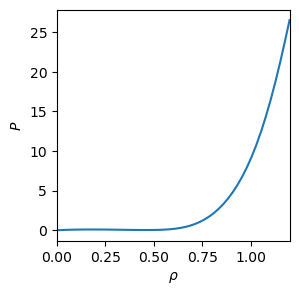

In [7]:
# computing the ideal contribution
pressure_ideal = density*temperature
# computing the residual contribution
pressure_residual = density**2 * dhelmholtz_drho

# computing the total pressure
pressure = pressure_ideal + pressure_residual

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.plot(density, pressure)
ax.set_xlim([0, 1.2])
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$P$")

### Internal Energy calculation

Similarly, the internal energy can also be computed from an ideal and a residual contribution.

$$U = U^{id} + U^{res}; \quad U^{id} = 1.5 T; \quad U^{res} = A^{res} - T \left( \frac{\partial A^{res}}{\partial T }\right)_{\rho}$$

Text(0, 0.5, '$U$')

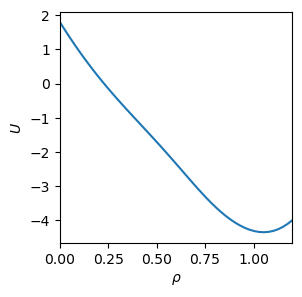

In [8]:
# computing the ideal contribution
internal_energy_ideal = 1.5 * temperature
# computing the residual contribution
internal_energy_residual = helmholtz - temperature * dhelmholtz_dT

# computing the total internal energy
internal_energy = internal_energy_ideal + internal_energy_residual

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.plot(density, internal_energy)
ax.set_xlim([0, 1.2])
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$U$")

## Second-order derivative properties calculation

Similarly, second-order derivatives properties, such as heat capacities, the isothermal compressibility and can be computed from the Helmholtz free energy derivatives.

### Isobaric Heat Capacity

The isobaric heat capacity is defined as follows:

$$ C_V = \left( \frac{\partial U}{\partial T}\right)_{\rho} = \underbrace{\left( \frac{\partial U^{id}}{\partial T}\right)_{\rho}}_{C_V^{id}} + \underbrace{ \left( \frac{\partial U^{res}}{\partial T}\right)_{\rho}}_{C_V^{res}}  $$

Where,

$$ C_V^{id} =  \left( \frac{\partial U^{id}}{\partial T}\right)_{\rho} = 1.5$$ 

$$ C_V^{res} =  \left( \frac{\partial U^{res}}{\partial T}\right)_{\rho} = -T \left( \frac{\partial^2 A^{res}}{\partial T^{2}}\right)_{\rho}$$ 

In [9]:
# computing the ideal contribution
cv_ideal = 1.5
# computing the residual contribution
cv_residual = - temperature * d2helmholtz_dT2

# computing the total isobaric heat capacity
cv = cv_ideal + cv_residual

Other second-order derivative properties can be defined using the density and temperature derivatives of the total pressure. The density derivative is computed as follows:

$$ \left( \frac{\partial P}{\partial \rho} \right)_{T} = \left( \frac{\partial P^{id}}{\partial \rho} \right)_{T} + \left( \frac{\partial P^{res}}{\partial \rho} \right)_{T} $$

Where: 
$$ \left( \frac{\partial P^{id}}{\partial \rho} \right)_{T} = T;  \quad  \left( \frac{\partial P^{res}}{\partial \rho} \right)_{T} = 2 \rho \left( \frac{\partial A^{res}}{\partial \rho }\right)_{T} + \rho^2 \left( \frac{\partial^2 A^{res}}{\partial \rho^2 }\right)_{T} $$ 

Similarly, the temperature derivative is computed as follows:

$$ \left( \frac{\partial P}{\partial T} \right)_{\rho} = \left( \frac{\partial P^{id}}{\partial T} \right)_{\rho} + \left( \frac{\partial P^{res}}{\partial T} \right)_{\rho} $$

Where: 
$$ \left( \frac{\partial P^{id}}{\partial T} \right)_{\rho} = \rho;  \quad  \left( \frac{\partial P^{res}}{\partial T} \right)_{\rho} =\rho^2 \left( \frac{\partial^2 A^{res}}{\partial T \partial \rho}\right) $$ 

In [10]:
dpressure_drho_resisual = 2*density*dhelmholtz_drho + density**2*d2helmholtz_drho2
dpressure_drho_ideal = 1.*temperature
dpressure_drho = dpressure_drho_ideal + dpressure_drho_resisual

dpressure_dT_resisual = density**2 * d2helmholtz_drho_dT
dpressure_dT_ideal = 1.*density
dpressure_dT = dpressure_dT_ideal + dpressure_dT_resisual

Then the other derivative properties are computed as follows:


### Thermal Pressure Coefficient

$$ \gamma_V = \left(\frac{\partial P}{\partial T} \right)_\rho $$

### Thermal  Expansion Coefficient

$$ \alpha_P = \frac{-1}{\rho} \left(\frac{\partial \rho}{\partial T} \right)_{P} = \left( \frac{\partial P}{\partial T} \right)_{\rho} \bigg/ \rho \left(\frac{\partial P}{\partial \rho} \right)_{T}  $$ 

### Isothermal Compressibility

$$ \kappa_T = \frac{1}{\rho} \left( \frac{\partial \rho}{\partial P} \right)_{T} = \left[ \rho \left( \frac{\partial P}{\partial \rho} \right)_{T} \right]^{-1} $$ 

### Isobaric Heat Capacity

$$ C_P = \left( \frac{\partial H}{\partial T} \right)_{P} = C_V + \frac{T \alpha_P^2}{\rho \kappa_T} $$

### Joule Thompson Coefficient

$$ \mu_{JT} = \left( \frac{\partial T}{\partial P} \right)_{H} = \frac{1}{\rho C_P} \left[T \alpha_P - 1 \right]$$ 

In [11]:
# Computing thermal pressure coefficient
thermal_pressure_coefficient = 1. * dpressure_dT

# Computing thermal expansion coefficient
thermal_expansion_coefficient = dpressure_dT/(density*dpressure_drho)

# Computing isothermal compressibility
isothermal_compressibility = 1/(density*dpressure_drho)

# Computing isobaric heat capacity
cp = temperature*thermal_expansion_coefficient**2/(density*isothermal_compressibility)
cp += cv

# Computing Joule-Thomson Coefficient
joule_thomson = temperature*thermal_expansion_coefficient - 1.
joule_thomson /= (density*cp)

Text(0, 0.5, '$\\mu_{JT}$')

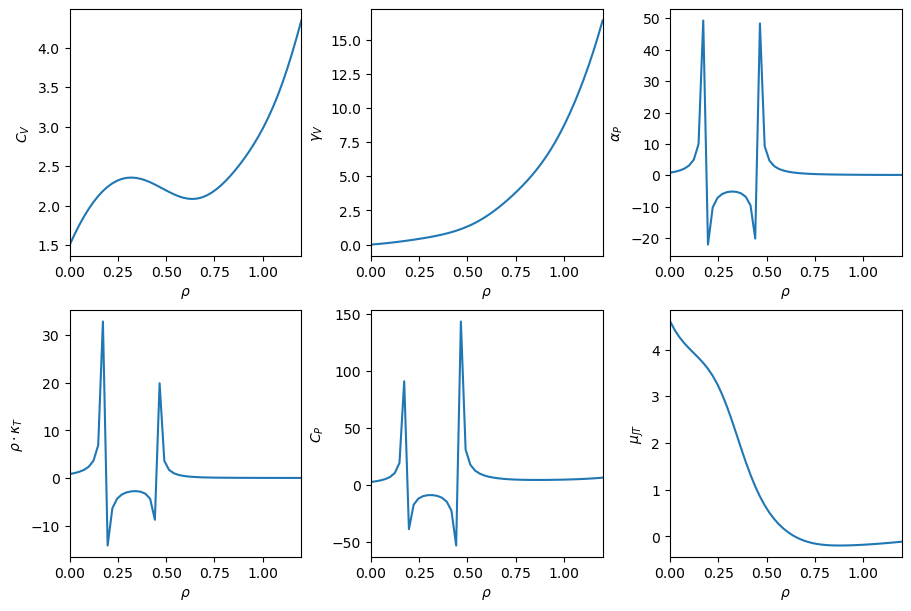

In [12]:
fig = plt.figure(figsize=(9,6), constrained_layout=True)
ax1 = fig.add_subplot(231)
ax1.plot(density, cv)
ax1.set_xlim([0, 1.2])
ax1.set_xlabel(r"$\rho$")
ax1.set_ylabel(r"$C_V$")

ax2 = fig.add_subplot(232)
ax2.plot(density, thermal_pressure_coefficient)
ax2.set_xlim([0, 1.2])
ax2.set_xlabel(r"$\rho$")
ax2.set_ylabel(r"$\gamma_V$")

ax3 = fig.add_subplot(233)
ax3.plot(density, thermal_expansion_coefficient)
ax3.set_xlim([0, 1.2])
ax3.set_xlabel(r"$\rho$")
ax3.set_ylabel(r"$\alpha_P$")

ax4 = fig.add_subplot(234)
ax4.plot(density, density*isothermal_compressibility)
ax4.set_xlim([0, 1.2])
ax4.set_xlabel(r"$\rho$")
ax4.set_ylabel(r"$\rho \cdot \kappa_T$")

ax5 = fig.add_subplot(235)
ax5.plot(density, cp)
ax5.set_xlim([0, 1.2])
ax5.set_xlabel(r"$\rho$")
ax5.set_ylabel(r"$C_P$")

ax6 = fig.add_subplot(236)
ax6.plot(density, joule_thomson)
ax6.set_xlim([0, 1.2])
ax6.set_xlabel(r"$\rho$")
ax6.set_ylabel(r"$\mu_{JT}$")

The `model` object also includes other handy functions to compute some properties directly. **These methods include the calculation of only residual contributions**. All of these methods use ($\alpha_{vdw}$, $\rho$ and $T$) as inputs.

- `model.pressure`: computes the pressure of the fluid
- `model.dpressure_drho`: computes the pressure of the fluid and its first density derivative
- `model.d2pressure_drho2`: computes the pressure of the fluid and its first and second-order density derivatives
- `model.dpressure_dT:` computes the pressure of the fluid and its first temperature derivative
- `model.internal_energy`: computes the internal energy of the fluid
- `model.enthalpy`: computes the enthalpy of the fluid
- `model.cv_residual`: computes the isochoric heat capacity of the fluid
- `model.chemical_potential`: computes the chemical potential of the fluid